In [1]:
# Generic OpenAI-compatible endpoint using ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from IPython.display import Image, display

import os
default_model_name = os.environ["OPENAI_MODEL"]
pg_connection = os.environ["PGVECTOR_CONNECTION_STRING"]
llm = ChatOpenAI(model=default_model_name,temperature=0)

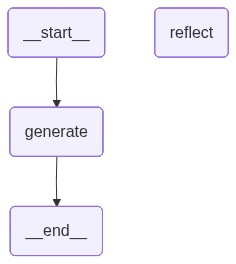

In [2]:
from typing import Annotated, TypedDict

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_openai import ChatOpenAI

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

model = llm

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

generate_prompt = SystemMessage(
    """Anda adalah asisten esai yang ditugaskan menulis esai 3-paragraf yang
        sangat baik."""
    "Hasilkan esai terbaik yang mungkin untuk permintaan pengguna."
    """Jika pengguna memberikan kritik, tanggapi dengan versi revisi dari
        upaya Anda sebelumnya."""
)

def generate(state: State) -> State:
    answer = model.invoke([generate_prompt] + state["messages"])
    return {"messages": [answer]}

reflection_prompt = SystemMessage(
    """Anda adalah guru yang menilai pengajuan esai. Hasilkan kritik dan
        rekomendasi untuk pengajuan pengguna."""
    """Berikan rekomendasi terperinci, termasuk permintaan untuk panjang, kedalaman,
        gaya, dll."""
)

def reflect(state: State) -> State:
    # Balikkan pesan untuk membuat LLM berefleksi pada keluaran sendiri
    cls_map = {AIMessage: HumanMessage, HumanMessage: AIMessage}
    # Pesan pertama adalah permintaan pengguna asli.
    # kita pertahankan sama untuk semua simpul
    translated = [reflection_prompt, state["messages"][0]] + [
        cls_map[msg.__class__](content=msg.content)
            for msg in state["messages"][1:]
    ]
    answer = model.invoke(translated)
    # kita perlakukan keluaran ini sebagai umpan balik manusia untuk generator
    return {"messages": [HumanMessage(content=answer.content)]}

def should_continue(state: State):
    if len(state["messages"]) > 6:
        # Berhenti setelah 3 iterasi, masing-masing dengan 2 pesan
        return END
    else:
        return "reflect"

builder = StateGraph(State)
builder.add_node("generate", generate)
builder.add_node("reflect", reflect)
builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

graph = builder.compile()
png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [3]:
input = {
  "messages": [
    HumanMessage("Kopi tanpa gula")
  ]
}
for c in graph.stream(input):
    print(c)

{'generate': {'messages': [AIMessage(content='**Kopi Tanpa Gula: Kenikmatan Sederhana yang Penuh Makna**\n\nKopi tanpa gula sering kali dianggap pahit dan tidak enak oleh sebagian orang, terutama mereka yang terbiasa dengan minuman manis. Namun, bagi banyak pencinta kopi sejati, kopi hitam tanpa tambahan gula justru menawarkan kenikmatan murni yang tidak bisa ditemukan dalam kopi manis. Rasa pahitnya bukanlah sesuatu yang perlu dihindari, melainkan bagian dari kompleksitas aroma dan cita rasa yang dihasilkan oleh biji kopi yang baik. Dengan menikmati kopi tanpa gula, seseorang dapat merasakan keaslian dari biji kopi itu sendiri, dari asal tanam hingga proses pemanggangannya.\n\nSelain memberikan pengalaman rasa yang otentik, kopi tanpa gula juga memiliki manfaat kesehatan yang lebih baik. Dengan tidak menambahkan gula, tubuh tidak perlu menangani lonjakan gula darah yang cepat, yang biasanya menyebabkan peningkatan energi jangka pendek diikuti dengan kelelahan. Kopi hitam juga kaya aka